In [1]:
# First import the libraries that we need to use
import pandas as pd
import requests
import json
from a_keys import API_PASS, API_KEY, API_SECRET
import coinbasepro as cbp

In [2]:
#cbp class
import json, hmac, hashlib, time, requests, base64
from requests.auth import AuthBase

class CoinbaseExchangeAuth(AuthBase):
    def __init__(self, api_key, secret_key, passphrase):
        self.api_key = api_key
        self.secret_key = secret_key
        self.passphrase = passphrase

    def __call__(self, request):
        timestamp = str(time.time())
        message = timestamp + request.method + request.path_url + (request.body or '')
        hmac_key = base64.b64decode(self.secret_key)
        signature = hmac.new(hmac_key, message, hashlib.sha256)
        signature_b64 = signature.digest().encode('base64').rstrip('\n')

        request.headers.update({
            'CB-ACCESS-SIGN': signature_b64,
            'CB-ACCESS-TIMESTAMP': timestamp,
            'CB-ACCESS-KEY': self.api_key,
            'CB-ACCESS-PASSPHRASE': self.passphrase,
            'Content-Type': 'application/json'
        })
        return request

api_url = 'https://api.pro.coinbase.com/'
auth = CoinbaseExchangeAuth(API_KEY, API_SECRET, API_PASS)

In [3]:
client = cbp.PublicClient()

In [4]:
# You can get list of coins on their site
# time granularity is based on seconds per step, so 3600 is an hour
# max call step is 300
data=client.get_product_historic_rates('ALGO-USD',granularity="3600")


In [5]:
df=pd.DataFrame(data)

In [6]:
df

,time,low,high,open,close,volume
0,2021-10-08 00:00:00,1.8777,1.9142,1.8915,1.9125,756200
1,2021-10-07 23:00:00,1.8673,1.8916,1.8801,1.8916,831532
2,2021-10-07 22:00:00,1.8652,1.9018,1.9014,1.8799,1877911
3,2021-10-07 21:00:00,1.8865,1.9175,1.9092,1.9022,1715117
4,2021-10-07 20:00:00,1.8793,1.9184,1.8833,1.9086,1870139
...,...,...,...,...,...,...
295,2021-09-25 17:00:00,1.722,1.751,1.7469,1.7251,1429510
296,2021-09-25 16:00:00,1.735,1.7696,1.7572,1.7473,1764097
297,2021-09-25 15:00:00,1.7181,1.7738,1.7292,1.7574,1340999
298,2021-09-25 14:00:00,1.7236,1.7694,1.7574,1.7297,2328317


# Data Cleaning, Conversions, and Visualization
1. The numeric values are not in float so have trouble being visualized via matplotlib
2. Time is running back per row, so for better plotting, sort with time going forwards
4. Set time as the new Index
3. Time step is in hours, so to get a more reactive algorithm, maybe create a second DF of 15 minute steps

In [7]:
def df_tonumeric_setindex(df):
    for column in df:
        if column =='time': 
            pass
        else:
            df[column]=pd.to_numeric(df[column])
    
    df=df.set_index('time').sort_index(ascending=True)
    return(df)



In [8]:
df=df_tonumeric_setindex(df)

In [9]:
df

,low,high,open,close,volume
time,,,,,
2021-09-25 13:00:00,1.7381,1.7729,1.7485,1.7572,953689
2021-09-25 14:00:00,1.7236,1.7694,1.7574,1.7297,2328317
2021-09-25 15:00:00,1.7181,1.7738,1.7292,1.7574,1340999
2021-09-25 16:00:00,1.7350,1.7696,1.7572,1.7473,1764097
2021-09-25 17:00:00,1.7220,1.7510,1.7469,1.7251,1429510
...,...,...,...,...,...
2021-10-07 20:00:00,1.8793,1.9184,1.8833,1.9086,1870139
2021-10-07 21:00:00,1.8865,1.9175,1.9092,1.9022,1715117
2021-10-07 22:00:00,1.8652,1.9018,1.9014,1.8799,1877911


<AxesSubplot:xlabel='time'>

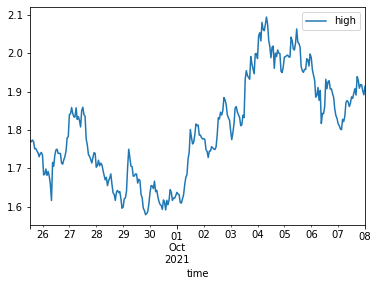

In [10]:
df.plot(y='high')

<AxesSubplot:xlabel='time'>

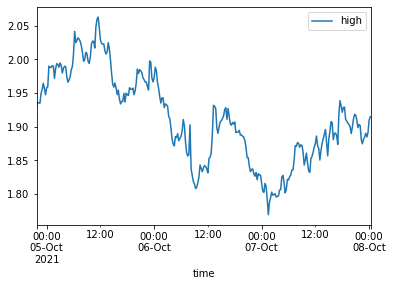

In [11]:
data2=client.get_product_historic_rates('ALGO-USD',granularity="900")
df2=pd.DataFrame(data2)
df2=df_tonumeric_setindex(df2)
df2.plot(y='high')

# Adding indicators

In [12]:
import ta
import talib as tal

In [32]:
#make sure to import these packages
from pandas import DataFrame
import talib.abstract as tab
#abstract automatically extracts the columns and periods from the data itself, no input required



#feel free to add or subtract more indicators for any other strategy you want to use
def populateindicators(dataframe) -> DataFrame:
        #exponential moving averages
        dataframe['ema_high'] = tab.EMA(dataframe, timeperiod=4, price='high')
        dataframe['ema_close'] = tab.EMA(dataframe, timeperiod=4, price='close')
        dataframe['ema_low'] = tab.EMA(dataframe, timeperiod=4, price='low')
        
        dataframe['dema_close'] = tab.DEMA(dataframe, timeperiod=4, price='close')
        dataframe['sema_high'] = tab.EMA(dataframe, timeperiod=10, price='high')
        dataframe['sema_close'] = tab.EMA(dataframe, timeperiod=10, price='close')
        dataframe['sema_low'] = tab.EMA(dataframe, timeperiod=10, price='low')
        
        dataframe['ssema_close'] = tab.EMA(dataframe, timeperiod=35, price='close')
        dataframe['sssema_close'] = tab.EMA(dataframe, timeperiod=40, price='close')
        dataframe['ssssema_close'] = tab.EMA(dataframe, timeperiod=45, price='close')
        dataframe['chaikosc'] = ta.ADOSC(dataframe['high'],dataframe['low'],dataframe['close'], np.asarray(dataframe['volume'], dtype='float'))
        
        dataframe['mfi'] = ta.MFI(dataframe['high'],dataframe['low'],dataframe['close'], np.asarray(dataframe['volume'], dtype='float'), timeperiod=14)
        dataframe['ultosc'] = ta.ULTOSC(dataframe['high'],dataframe['low'],dataframe['close'])
        dataframe['obv'] = ta.OBV(dataframe['close'], np.asarray(dataframe['volume'], dtype='float'))
        
        
        dataframe['minusdi'] = tab.MINUS_DI(dataframe, timeperiod=14)
        dataframe['longminusdi'] = tab.MINUS_DI(dataframe, timeperiod=28)
        dataframe['plusdi'] = tab.PLUS_DI(dataframe, timeperiod=14)
        
        dataframe['longminusdi'] = tab.MINUS_DI(dataframe, timeperiod=35)
        dataframe['longplusdi'] = tab.PLUS_DI(dataframe, timeperiod=35)
        dataframe['splusdi'] = tab.PLUS_DI(dataframe, timeperiod=7)
        dataframe['sma']=tab.SMA(dataframe, timeperiod=10, price='close')
        dataframe['vwap']=dataframe['sma']*dataframe['volume']
        
        dataframe['emaminussdi'] = ta.MINUS_DI(dataframe['ema_high'],dataframe['ema_low'],dataframe['ema_close'])
        dataframe['emaplusdi'] = ta.PLUS_DI(dataframe['ema_high'],dataframe['ema_low'],dataframe['ema_close'])
        dataframe['emaadx'] = ta.ADX(dataframe['ema_high'],dataframe['ema_low'],dataframe['ema_close'])
        
        dataframe['upperband'], dataframe['midband'], dataframe['lowerband'] = ta.BBANDS(dataframe['close'], timeperiod=5, nbdevup=1, nbdevdn=1, matype=0)
        
        dataframe['macd'],dataframe['macdsig'],dataframe['hist']= ta.MACD(dataframe['close'], fastperiod=12, slowperiod=26, signalperiod=9)
        dataframe['rsi'] = tab.RSI(dataframe, timeperiod=14, price='close')
        dataframe['adx'] = tab.ADX(dataframe)
        dataframe['shortadx'] = tab.ADX(dataframe, timeperiod=10)
        dataframe['srsi'] = tab.RSI(dataframe, timeperiod=3, price='close')
        dataframe["upperband"], dataframe["middleband"], dataframe["lowerband"] = ta.BBANDS(dataframe['close'],  nbdevup=1.5, nbdevdn=1.5)
        
        dataframe['ema_ultosc'] = ta.ULTOSC(dataframe['ema_high'],dataframe['ema_low'],dataframe['ema_close'])
        dataframe['ema_rsi'] = ta.RSI(dataframe['ema_close'], timeperiod=3)
        dataframe['fema_rsi'] = ta.RSI(dataframe['ema_close'], timeperiod=2)
        dataframe['sema_rsi'] = ta.RSI(dataframe['ema_close'], timeperiod=6)
        
        
        dataframe['beta'] = tab.BETA(dataframe)
        
        dataframe['macd1'],dataframe['macdsig1'],dataframe['hist1']= ta.MACD(dataframe['close'], fastperiod=8, slowperiod=10, signalperiod=7)

        
        return dataframe

In [33]:
data4=populateindicators(df)

/tmp/ipykernel_15049/4160826760.py:31: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_15049/4160826760.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_15049/4160826760.py:35: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_15049/4160826760.py:36: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

In [34]:
data4

,low,high,open,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,...,srsi,middleband,ema_ultosc,ema_rsi,fema_rsi,sema_rsi,beta,macd1,macdsig1,hist1
time,,,,,,,,,,,,,,,,,,,,,
2021-09-25 13:00:00,1.7381,1.7729,1.7485,1.7572,953689,9.317651e+04,953689,0.097701,0.000000,50.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-25 14:00:00,1.7236,1.7694,1.7574,1.7297,2328317,-1.614934e+06,-1374628,-0.492057,-64028.717500,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-25 15:00:00,1.7181,1.7738,1.7292,1.7574,1340999,-1.063607e+06,-33629,-0.230068,-49575.233243,36.664184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-25 16:00:00,1.7350,1.7696,1.7572,1.7473,1764097,-1.573462e+06,-1797726,-0.246350,-45038.397022,57.279418,...,42.419602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-25 17:00:00,1.7220,1.7510,1.7469,1.7251,1429510,-2.697353e+06,-3227236,-0.345080,-43137.929162,45.421828,...,28.093306,1.74334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-07 20:00:00,1.8793,1.9184,1.8833,1.9086,1870139,2.236279e+06,37086838,0.133641,17776.445617,59.500284,...,66.492198,1.89312,52.631474,87.905249,89.359231,81.728189,0.094745,0.004385,0.003532,0.000854
2021-10-07 21:00:00,1.8865,1.9175,1.9092,1.9022,1715117,2.258410e+06,35371721,0.132395,13668.846415,53.729294,...,58.649235,1.90080,51.757329,89.852006,92.317536,82.961759,0.109896,0.004271,0.003716,0.000555
2021-10-07 22:00:00,1.8652,1.9018,1.9014,1.8799,1877911,1.888985e+06,33493810,0.132798,5733.666170,48.699226,...,36.281855,1.89358,50.430924,54.276247,36.786956,68.004855,0.665684,0.003125,0.003569,-0.000444


# Visualize through Dtale

In [15]:
#pip install dtale to get dependancies
import dtale
import plotly

In [16]:
dtale.show(df2)